<a href="https://colab.research.google.com/github/jhlee508/pytorch-advanced/blob/master/chapter4_pose_estimation_OpenPose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Git Clone

In [1]:
!git clone https://github.com/YutaroOgawa/pytorch_advanced.git

Cloning into 'pytorch_advanced'...
remote: Enumerating objects: 548, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 548 (delta 34), reused 45 (delta 18), pack-reused 479
Receiving objects: 100% (548/548), 17.75 MiB | 33.85 MiB/s, done.
Resolving deltas: 100% (293/293), done.


In [2]:
%cd pytorch_advanced/

/content/pytorch_advanced


In [3]:
!ls

1_image_classification	 7_nlp_sentiment_transformer
2_objectdetection	 8_nlp_sentiment_bert
3_semantic_segmentation  9_video_classification_eco
4_pose_estimation	 etc
5_gan_generation	 LICENSE
6_gan_anomaly_detection  README.md


In [4]:
%cd 4_pose_estimation/

/content/pytorch_advanced/4_pose_estimation


In [5]:
!pwd

/content/pytorch_advanced/4_pose_estimation


In [6]:
!ls

4-2_DataLoader.ipynb	     4-7_OpenPose_inference.ipynb
4-3-4_NetworkModel.ipynb     data
4-5_TensorBoardX.ipynb	     make_folders_and_data_downloads.ipynb
4-6_OpenPose_training.ipynb  utils


### Make Folders and Data Downloads

In [7]:
import os
import urllib.request
import zipfile
import tarfile

In [8]:
# "data" 폴더가 존재하지 않는 경우 작성한다
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [9]:
# "weights" 폴더가 존재하지 않는 경우 작성한다
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [10]:
# MSCOCO의 2014 Val images [41K/6GB]를 다운로드
# 6GB 파일의 다운로드 및 압축 해제에 시간이 걸립니다(약 10분)
url =  "http://images.cocodataset.org/zips/val2014.zip"
target_path = os.path.join(data_dir, "val2014.zip") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    zip = zipfile.ZipFile(target_path)
    zip.extractall(data_dir)  # ZIP 파일 압축 해제
    zip.close()  # ZIP 파일 닫기

tensorboy의 GitHub에서 필요한 데이터를 수동으로 다운로드
tensorboy가 COCODataset에서 사용하기 쉽도록 가공한 데이터를 이용합니다

https://github.com/tensorboy/pytorch_Realtime_Multi-Person_Pose_Estimation

Released under the MIT license

In [11]:
# 화상 데이터의 어노테이션 데이터를 정리한 "COCO.json" 파일을 다운로드합니다
# "data" 폴더에 이하 데이터를 배치
# "COCO.json" 어노테이션 데이터
# https://www.dropbox.com/s/0sj2q24hipiiq5t/COCO.json?dl=0

url = "https://www.dropbox.com/s/0sj2q24hipiiq5t/COCO.json?dl=1"  # dl=1 to force download
target_path = os.path.join(data_dir, "COCO.json") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [13]:
# 화상 중에서 어노테이션 데이터(사람의 관절 위치 정보)가 없는 사람 부분을 마스크하는 데이터를 준비합니다
# "data" 폴더에 이하 데이터를 배치
# "mask.tar.gz" 마스크 데이터
# https://www.dropbox.com/s/bd9ty7b4fqd5ebf/mask.tar.gz?dl=0

url = "https://www.dropbox.com/s/bd9ty7b4fqd5ebf/mask.tar.gz?dl=1"  
target_path = os.path.join(data_dir, "mask.tar.gz") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

# mask.tar.gz 압축 해제
with tarfile.open(target_path, 'r:*') as tar:
    tar.extractall(data_dir)

In [14]:
# tensorboy의 학습된 OpenPose 모델 "pose_model_scratch.pth"를 준비합니다
# "weights" 폴더에 이하 데이터를 배치
# 학습된 모델 "pose_model_scratch.pth"
# https://www.dropbox.com/s/5v654d2u65fuvyr/pose_model_scratch.pth?dl=0

url = "https://www.dropbox.com/s/5v654d2u65fuvyr/pose_model_scratch.pth?dl=1" 
target_path = os.path.join(weights_dir, "pose_model_scratch.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

# Chapter4. 자세 추정(OpenPose)

## 4.2 DataLoader 작성

### Import Libraries

In [15]:
# 필요한 패키지 import
import json
import os
import os.path as osp
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data

### Data to List

In [16]:
def make_datapath_list(rootpath):
    """
    학습 및 검증의 화상 데이터와 어노테이션 데이터, 마스크 데이터의 파일 경로 리스트를 작성한다.
    """

    # 어노테이션의 JSON 파일을 읽기
    json_path = osp.join(rootpath, 'COCO.json')
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']

    # index를 저장
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    for count in range(num_samples):
        if data_json[count]['isValidation'] != 0.:
            val_indexes.append(count)
        else:
            train_indexes.append(count)

    # 화상 파일 경로를 저장
    train_img_list = list()
    val_img_list = list()

    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)

    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)

    # 마스크 데이터의 경로를 저장
    train_mask_list = []
    val_mask_list = []

    for idx in train_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/train2014/mask_COCO_train2014_" + img_idx+'.jpg'
        train_mask_list.append(anno_path)

    for idx in val_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/val2014/mask_COCO_val2014_" + img_idx+'.jpg'
        val_mask_list.append(anno_path)

    # 어노테이션 데이터를 저장
    train_meta_list = list()
    val_meta_list = list()

    for idx in train_indexes:
        train_meta_list.append(data_json[idx])

    for idx in val_indexes:
        val_meta_list.append(data_json[idx])

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list

In [17]:
# 동작 확인(실행에는 10초 정도 걸립니다)
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="./data/")

val_meta_list[24]

{'annolist_index': 18.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'bbox_other': [[112.24, 245.32, 127.0, 110.76],
  [34.67, 208.02, 91.24, 152.36]],
 'dataset': 'COCO_val',
 'image_id': 488.0,
 'img_height': 406.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'isValidation': 1.0,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [127.0, 311.0, 1.0],
   [170.0, 307.0, 1.0],
   [180.0, 310.0, 1.0],
   [140.0, 341.0, 1.0],
   [148.0, 346.0, 1.0]],
  [[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [106.0, 227.0, 1.0],
   [92.0, 232.0, 1.0],
   [101.0, 232.0, 1.0],
   [0.0, 0.0, 2.0],
   [97.0, 257.0, 1.0],
   [0.0, 0.0, 2.0],
   [94.0, 282.0, 1.0],
   [55.0, 270.0, 1.0],
   [65.0, 271.0, 1.0

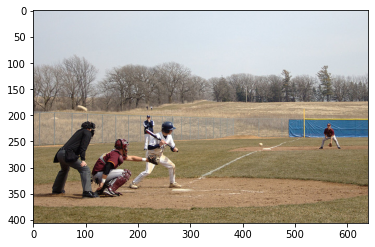

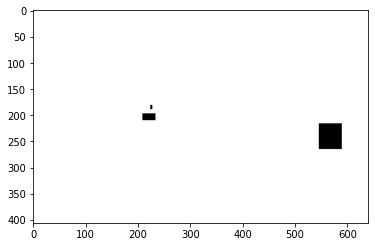

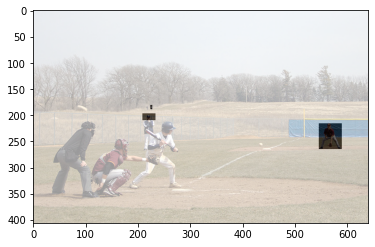

In [18]:
index = 24

# 화상
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# 마스크
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

# 합성
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

### Image Preprocessor




In [19]:
# 데이터 처리 클래스와 데이터 확장 클래스를 import
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor

class DataTransform():
    """
    화상과 마스크, 어노테이션의 전처리 클래스.
    학습시와 추론시에 서로 다르게 동작한다.
    학습시에는 데이터 확장을 수행한다.
    """

    def __init__(self):

        self.data_transform = {
            'train': Compose([
                get_anno(),  # JSON에서 어노테이션을 사전에 저장
                add_neck(),  # 어노테이션 데이터의 순서를 변경하고, 목의 어노테이션 데이터를 추가
                aug_scale(),  # 확대 축소
                aug_rotate(),  # 회전
                aug_croppad(),  # 자르기
                aug_flip(),  # 좌우 반전
                remove_illegal_joint(),  # 화상에서 밀려나온 어노테이션을 제거
                # Normalize_Tensor()  # 색상 정보의 표준화 및 텐서화
                no_Normalize_Tensor()  # 여기서는 색상 정보의 표준화를 생략
            ]),
            'val': Compose([
                # 검증을 생략
            ])
        }

    def __call__(self, phase, meta_data, img, mask_miss):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리의 모드를 지정.
        """
        meta_data, img, mask_miss = self.data_transform[phase](
            meta_data, img, mask_miss)

        return meta_data, img, mask_miss

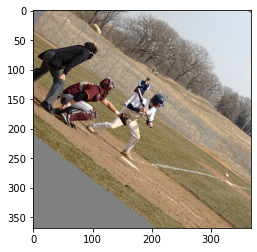

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


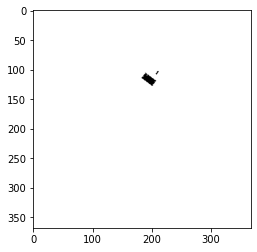

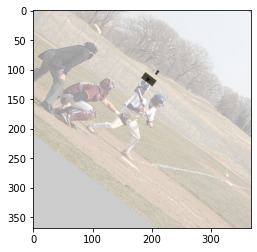

In [20]:
# 동작 확인
# 화상 읽기
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meat_data = val_meta_list[index]

# 화상 전처리
transform = DataTransform()
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

# 화상 표시
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

# 마스크 표시
mask_miss = mask_miss.numpy().transpose((1, 2, 0))
plt.imshow(mask_miss)
plt.show()

# 합성 RGB 정보 갖추기
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()

### Change Annotation 

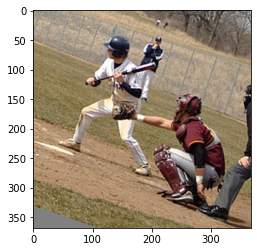

In [86]:
from utils.dataloader import get_ground_truth

# 화상 읽기
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meat_data = val_meta_list[index]

# 화상 전처리
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# OpenPose의 어노테이션 데이터 생성
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# 화상 표시
plt.imshow(img)
plt.show()

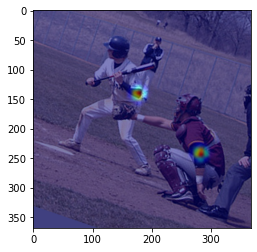

In [87]:
# 왼쪽 팔꿈치의 heatmap를 확인

# 원래 화상
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

# 왼쪽 팔꿈치
heat_map = heatmaps[:, :, 6]  # 6은 왼쪽 팔꿈치
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map.numpy())*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# 주의: heatmap은 화상 크기가 1/8으로 되어 있으므로 확대한다

# 합성해서 표시
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

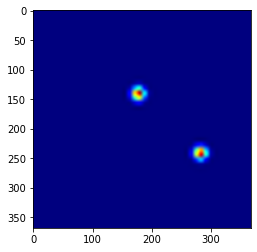

In [88]:
plt.imshow(heat_map)
plt.show()

In [120]:
# 히트맵 값 확인
heat_map = heatmaps[:, :, 6]  # 6은 왼쪽 팔꿈치
np.unique(heat_map) # 0 ~ 1 사이의 값

array([0.        , 0.01187752, 0.01461208, 0.01506235, 0.01524512,
       0.01751763, 0.01770573, 0.01776083, 0.0224909 , 0.02790714,
       0.0336797 , 0.03412246, 0.03557867, 0.03622138, 0.03812654,
       0.04487969, 0.0469763 , 0.05784434, 0.06868628, 0.07426639,
       0.08099169, 0.0853369 , 0.10035182, 0.10224233, 0.10270881,
       0.13065449, 0.13499564, 0.15093017, 0.16138373, 0.19537188,
       0.22266503, 0.29399574, 0.30698284, 0.31419304, 0.35223695,
       0.38929725, 0.40474308, 0.43372754, 0.46982299, 0.58212875,
       0.59711145, 0.68611973, 0.73822083, 0.914684  , 0.94457903])

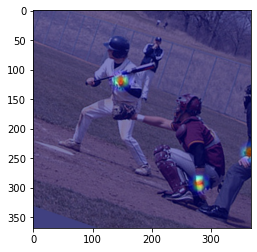

In [89]:
# 왼쪽 손목
heat_map = heatmaps[:, :, 7]  # 7은 왼쪽 손목
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map.numpy())*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 합성해서 표시
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()

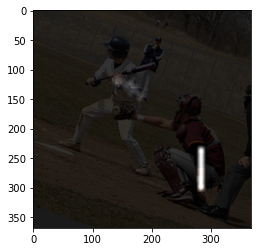

In [90]:
# 왼쪽 팔꿈치와 왼쪽 손목에 PAF를 확인
paf = pafs[:, :, 24]  # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x 벡터의 PAF

paf = Image.fromarray(np.uint8((paf.numpy())*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)

# 합성해서 표시
blend_img = cv2.addWeighted(img, 0.2, paf, 1.0, 0)
plt.imshow(blend_img)
plt.show()

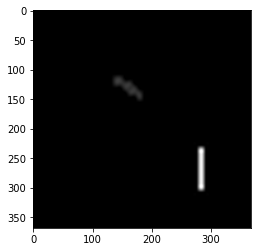

In [142]:
# PAF만 표시
paf = pafs[:, :, 24]  # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x 벡터의 PAF
paf = Image.fromarray(np.uint8((paf.numpy())*255))
paf = np.asarray(paf.convert('RGB'))
paf = cv2.resize(
    paf, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(paf)
plt.show()

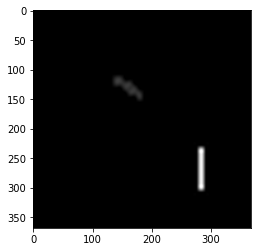

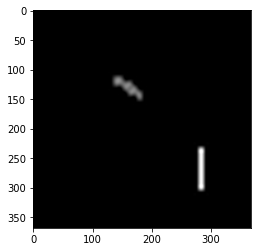

In [152]:
# PAFs의 (x, y) 전부 표시
pafx = pafs[:, :, 24]  # 24는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 x 벡터의 PAF
pafy = pafs[:, :, 25]  # 25는 왼쪽 팔꿈치와 왼쪽 손목을 잇는 y 벡터의 PAF
pafx = Image.fromarray(np.uint8((pafx.numpy())*255))
pafy = Image.fromarray(np.uint8((pafy.numpy())*255))
pafx = np.asarray(pafx.convert('RGB'))
pafy = np.asarray(pafy.convert('RGB'))
pafx = cv2.resize(
    pafx, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
pafy = cv2.resize(
    pafy, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
plt.imshow(pafx)
plt.show()
plt.imshow(pafy)
plt.show()

In [143]:
# PAFs 값 확인
paf = pafs[:, :, 24]
print(np.unique(paf))
paf = paf * 255
print(np.unique(paf))
paf = np.uint8(paf)
print(np.unique(paf))

[-0.82100522 -0.03786132  0.        ]
[-209.35633219   -9.65463614    0.        ]
[  0  47 247]


### Define Dataset

In [105]:
from utils.dataloader import get_ground_truth

class COCOkeypointsDataset(data.Dataset):
    """
    MSCOCO Cocokeypoints의 Dataset를 작성하는 클래스. PyTorch Dataset 클래스를 상속.

    Attributes
    ----------
    img_list : 리스트
        화상 경로를 저장한 리스트
    anno_list : 리스트
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련을 설정.
    transform : object
        전처리 클래스의 인스턴스
    """

    def __init__(self, img_list, mask_list, meta_list, phase, transform):
        self.img_list = img_list
        self.mask_list = mask_list
        self.meta_list = meta_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''화상 매수를 반환한다'''
        return len(self.img_list)

    def __getitem__(self, index):
        img, heatmaps, heat_mask, pafs, paf_mask = self.pull_item(index)
        return img, heatmaps, heat_mask, pafs, paf_mask

    def pull_item(self, index):
        '''화상의 Tensor 형식 데이터, 어노테이션, 마스크를 취득한다'''

        # 1. 화상 읽기
        image_file_path = self.img_list[index]
        img = cv2.imread(image_file_path)  # [높이][폭][색BGR]

        # 2. 마스크와 어노테이션 읽기
        mask_miss = cv2.imread(self.mask_list[index])
        meat_data = self.meta_list[index]

        # 3. 화상 전처리
        meta_data, img, mask_miss = self.transform(
            self.phase, meat_data, img, mask_miss)

        # 4. 정답 어노테이션 데이터 취득
        mask_miss_numpy = mask_miss.numpy().transpose((1, 2, 0))
        heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(
            meta_data, mask_miss_numpy)

        # 5. 마스크 데이터는 RGB가 (255,255,255) 또는 (0,0,0)이므로, 차원을 낮춘다
        # 마스크된 위치는 값이 0, 그렇지 않으면 1입니다
        heat_mask = heat_mask[:, :, :, 0]
        paf_mask = paf_mask[:, :, :, 0]

        # 6. 채널이 맨 끝에 있으므로, 순서를 변경
        # 예: paf_mask: torch.Size([46, 46, 38])
        # → torch.Size([38, 46, 46])
        paf_mask = paf_mask.permute(2, 0, 1)
        heat_mask = heat_mask.permute(2, 0, 1)
        pafs = pafs.permute(2, 0, 1)
        heatmaps = heatmaps.permute(2, 0, 1)

        return img, heatmaps, heat_mask, pafs, paf_mask

In [106]:
# 동작 확인
train_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="train", transform=DataTransform())
val_dataset = COCOkeypointsDataset(
    val_img_list, val_mask_list, val_meta_list, phase="val", transform=DataTransform())

# 데이터 꺼내기 예
item = train_dataset.__getitem__(0)
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask

torch.Size([3, 368, 368])
torch.Size([19, 46, 46])
torch.Size([19, 46, 46])
torch.Size([38, 46, 46])
torch.Size([38, 46, 46])


### Define DataLoader

In [107]:
# 데이터 로더 작성
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수에 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["train"])  # 반복으로 변환
item = next(batch_iterator)  # 1번째 요소를 꺼낸다
print(item[0].shape)  # img
print(item[1].shape)  # heatmaps,
print(item[2].shape)  # heat_mask
print(item[3].shape)  # pafs 
print(item[4].shape)  # paf_mask

torch.Size([8, 3, 368, 368])
torch.Size([8, 19, 46, 46])
torch.Size([8, 19, 46, 46])
torch.Size([8, 38, 46, 46])
torch.Size([8, 38, 46, 46])


## 4.3 OpenPose Network

### OpenPoseNet

In [154]:
# 필요한 패키지 import
import torch
import torch.nn as nn
from torch.nn import init
import torchvision

In [168]:
# 각 모듈의 출력층 Concatenation 한 결과의 shape
minibatch = 8

feature = torch.randn(minibatch, 128, 46, 46) # feature
branch_1 = torch.randn(minibatch, 38, 46, 46) # stage1_1 
branch_2 = torch.randn(minibatch, 19, 46, 46) # stage1_2

output = torch.cat([feature, branch_1, branch_2], dim=1)
print("결과 출력층의 Shape:", output.shape)

결과 출력층의 Shape: torch.Size([8, 185, 46, 46])


In [164]:
class OpenPoseNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Feature 모듈
        self.model0 = OpenPose_Feature()

        # Stage 모듈
        # PAFs(Part Affinity Fields) 측
        self.model1_1 = make_OpenPose_block('block1_1')
        self.model2_1 = make_OpenPose_block('block2_1')
        self.model3_1 = make_OpenPose_block('block3_1')
        self.model4_1 = make_OpenPose_block('block4_1')
        self.model5_1 = make_OpenPose_block('block5_1')
        self.model6_1 = make_OpenPose_block('block6_1')

        # confidence heatmap 측
        self.model1_2 = make_OpenPose_block('block1_2')
        self.model2_2 = make_OpenPose_block('block2_2')
        self.model3_2 = make_OpenPose_block('block3_2')
        self.model4_2 = make_OpenPose_block('block4_2')
        self.model5_2 = make_OpenPose_block('block5_2')
        self.model6_2 = make_OpenPose_block('block6_2')

    def forward(self, x):
        """순전파 정의"""

        # Feature 모듈
        out1 = self.model0(x)

        # Stage1
        out1_1 = self.model1_1(out1)  # PAFs 측
        out1_2 = self.model1_2(out1)  # confidence heatmap 측

        # CStage2
        out2 = torch.cat([out1_1, out1_2, out1], 1)  # 1차원의 채널 결합
        out2_1 = self.model2_1(out2)
        out2_2 = self.model2_2(out2)

        # Stage3
        out3 = torch.cat([out2_1, out2_2, out1], 1)
        out3_1 = self.model3_1(out3)
        out3_2 = self.model3_2(out3)

        # Stage4
        out4 = torch.cat([out3_1, out3_2, out1], 1)
        out4_1 = self.model4_1(out4)
        out4_2 = self.model4_2(out4)

        # Stage5
        out5 = torch.cat([out4_1, out4_2, out1], 1)
        out5_1 = self.model5_1(out5)
        out5_2 = self.model5_2(out5)

        # Stage6
        out6 = torch.cat([out5_1, out5_2, out1], 1)
        out6_1 = self.model6_1(out6)
        out6_2 = self.model6_2(out6)

        # 손실의 계산을 위해 각 Stage 결과를 저장
        saved_for_loss = []
        saved_for_loss.append(out1_1)  # PAFs 측
        saved_for_loss.append(out1_2)  # confidence heatmap 측
        saved_for_loss.append(out2_1)
        saved_for_loss.append(out2_2)
        saved_for_loss.append(out3_1)
        saved_for_loss.append(out3_2)
        saved_for_loss.append(out4_1)
        saved_for_loss.append(out4_2)
        saved_for_loss.append(out5_1)
        saved_for_loss.append(out5_2)
        saved_for_loss.append(out6_1)
        saved_for_loss.append(out6_2)

        # 최종적인 PAFs의 out6_1과 confidence heatmap의 out6_2, 그리고
        # 손실 계산용으로 각 단계에서 PAFs와 heatmap을 저장한 saved_for_loss를 출력
        # out6_1: torch.Size([minibatch, 38, 46, 46])
        # out6_2: torch.Size([minibatch, 19, 46, 46])
        # saved_for_loss:[out1_1, out_1_2, ・・・, out6_2]

        return (out6_1, out6_2), saved_for_loss

### Feature 모듈

In [170]:
vgg19_temp = torchvision.models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [173]:
vgg19_temp

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [174]:
class OpenPose_Feature(nn.Module):
    def __init__(self):
        super(OpenPose_Feature, self).__init__()

        # VGG-19의 최초 10개의 합성곱 층을 사용
        # 처음 실행할 때에는 학습된 파라미터를 다운로드하므로 실행에 시간이 걸립니다
        vgg19 = torchvision.models.vgg19(pretrained=True)
        model = {}
        model['block0'] = vgg19.features[0:23]  # VGG-19의 최초 10개의 합성곱 층까지

        # 나머지는 새로운 합성곱 층을 2개 준비
        model['block0'].add_module("23", torch.nn.Conv2d(
            512, 256, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module("24", torch.nn.ReLU(inplace=True))
        model['block0'].add_module("25", torch.nn.Conv2d(
            256, 128, kernel_size=3, stride=1, padding=1))
        model['block0'].add_module("26", torch.nn.ReLU(inplace=True))

        self.model = model['block0']

    def forward(self, x):
        outputs = self.model(x)
        return outputs

### Stage 모듈

In [175]:
def make_OpenPose_block(block_name):
    """
    구성 변수에서 OpenPose의 Stage모듈의 block을 작성
    nn.Module이 아니라, nn.Sequential로 한다
    """

    # 1. 구성의 사전형 변수 blocks을 작성하여, 네트워크를 생성시킨다
    # 먼저 전 패턴의 사전을 준비하여, block_name 인수만을 생성한다
    blocks = {}
    # Stage 1
    blocks['block1_1'] = [{'conv5_1_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L1': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L1': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L1': [512, 38, 1, 1, 0]}]

    blocks['block1_2'] = [{'conv5_1_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_2_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_3_CPM_L2': [128, 128, 3, 1, 1]},
                          {'conv5_4_CPM_L2': [128, 512, 1, 1, 0]},
                          {'conv5_5_CPM_L2': [512, 19, 1, 1, 0]}]

    # Stages 2 - 6
    for i in range(2, 7):
        blocks['block%d_1' % i] = [
            {'Mconv1_stage%d_L1' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L1' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L1' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L1' % i: [128, 38, 1, 1, 0]}
        ]

        blocks['block%d_2' % i] = [
            {'Mconv1_stage%d_L2' % i: [185, 128, 7, 1, 3]},
            {'Mconv2_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv3_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv4_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv5_stage%d_L2' % i: [128, 128, 7, 1, 3]},
            {'Mconv6_stage%d_L2' % i: [128, 128, 1, 1, 0]},
            {'Mconv7_stage%d_L2' % i: [128, 19, 1, 1, 0]}
        ]

    # block_name 인수의 구성 사전을 꺼낸다
    cfg_dict = blocks[block_name]

    # 2. 구성 내용을 리스트 변수 layers에 저장
    layers = []

    # 0번째부터 최후의 층까지 작성
    for i in range(len(cfg_dict)):
        for k, v in cfg_dict[i].items():
            if 'pool' in k:
                layers += [nn.MaxPool2d(kernel_size=v[0], stride=v[1],
                                        padding=v[2])]
            else:
                conv2d = nn.Conv2d(in_channels=v[0], out_channels=v[1],
                                   kernel_size=v[2], stride=v[3],
                                   padding=v[4])
                layers += [conv2d, nn.ReLU(inplace=True)]

    # 3. layers를 Sequential로 한다
    # 단, 최후에 ReLU는 필요 없으므로 직전까지를 사용한다
    net = nn.Sequential(*layers[:-1])

    # 4. 초기화 함수를 설정하여, 합성곱 층을 초기화한다
    def _initialize_weights_norm(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.normal_(m.weight, std=0.01)
                if m.bias is not None:
                    init.constant_(m.bias, 0.0)

    net.apply(_initialize_weights_norm)

    return net

In [176]:
# 모델 정의
net = OpenPoseNet()
print(net)

OpenPoseNet(
  (model0): OpenPose_Feature(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=Tru

In [177]:
# 동작 확인
net.train()
# 더미 데이터 작성
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 368, 368)

# 계산
outputs = net(dummy_img)
print(outputs)

((tensor([[[[ 2.5234e-05,  8.2490e-06, -2.8113e-05,  ..., -1.3905e-05,
           -2.3236e-05, -2.1073e-05],
          [ 1.4882e-05,  3.7302e-05, -7.8668e-06,  ..., -1.8177e-05,
           -2.0260e-05, -9.0797e-06],
          [ 5.4704e-05,  3.3432e-05,  1.2221e-05,  ...,  1.8836e-06,
           -1.3437e-05, -7.3084e-06],
          ...,
          [ 2.7263e-05,  3.0093e-05,  2.4907e-05,  ...,  3.6211e-06,
            1.3049e-05,  3.1680e-05],
          [ 3.1779e-05,  1.6179e-05,  3.0086e-05,  ..., -2.3089e-05,
           -1.7057e-05, -1.2033e-06],
          [ 2.9014e-05,  3.2801e-05,  2.4931e-05,  ...,  2.6783e-05,
            1.9098e-06,  4.2957e-06]],

         [[ 4.1340e-05,  3.8454e-05,  3.1867e-05,  ...,  4.9663e-06,
            1.3369e-06, -9.9718e-06],
          [ 4.9277e-05,  6.8495e-05,  4.2059e-05,  ...,  1.3632e-05,
            1.5464e-05,  1.6262e-06],
          [ 7.9552e-05,  3.5571e-05,  2.7930e-05,  ..., -2.0001e-05,
            1.8710e-05,  2.3501e-05],
          ...,
   